In [1]:
"""
r: Zongyi Li and Daniel Zhengyu Huang
"""

import numpy
import torch.nn.functional as F
import matplotlib.pyplot as plt
from timeit import default_timer
from catheter import *
from catheter import FNO1d, FNO1d_updated
from utilities3 import *
from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device is ", (device))

device is  cuda


In [2]:
def Lx2length(L_x, L_p, x1, x2, x3, h):
    l0, l1, l2, l3 = -x3, torch.sqrt((x2-x3)**2 + h**2), torch.sqrt((x1-x2)**2 + h**2), L_p+x1
    if L_x < -x3:
        l = L_x
    elif L_x < -x2:
        l = l0 + l1*(L_x + x3)/(x3-x2)
    elif L_x < -x1:
        l = l0 + l1 + l2*(L_x + x2)/(x2-x1)
    else:
        l = l0 + l1 + l2 + L_x+x1

    return l

def d2xy(d, L_p, x1, x2, x3, h):
    
    p0, p1, p2, p3 = torch.tensor([0.0,0.0]), torch.tensor([x3,0.0]), torch.tensor([x2, h]), torch.tensor([x1,0.0])
    v0, v1, v2, v3 = torch.tensor([x3-0,0.0]), torch.tensor([x2-x3,h]), torch.tensor([x1-x2,-h]), torch.tensor([-L_p-x1,0.0])
    l0, l1, l2, l3 = -x3, torch.sqrt((x2-x3)**2 + h**2), torch.sqrt((x1-x2)**2 + h**2), L_p+x1
    
    xx, yy = torch.zeros(d.shape), torch.zeros(d.shape)
    ind = (d < l0)
    xx[ind] = d[ind]*v0[0]/l0 + p0[0]
    yy[ind] = d[ind]*v0[1]/l0 + p0[1]
    
    ind = torch.logical_and(d < l0 + l1, d>=l0)
    xx[ind] = (d[ind]-l0)*v1[0]/l1 + p1[0] 
    yy[ind] = (d[ind]-l0)*v1[1]/l1 + p1[1]
    
    ind = torch.logical_and(d < l0 + l1 + l2, d>=l0 + l1)
    xx[ind] = (d[ind]-l0-l1)*v2[0]/l2 + p2[0]
    yy[ind] = (d[ind]-l0-l1)*v2[1]/l2 + p2[1]
    
    ind = (d>=l0 + l1 + l2)
    xx[ind] = (d[ind]-l0-l1-l2)*v3[0]/l3 + p3[0]
    yy[ind] = (d[ind]-l0-l1-l2)*v3[1]/l3 + p3[1]
    

    return xx, yy

def catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s):
    x1 = -0.5*L_p
    # ncy = 20
    
    n_periods = torch.floor(L_x / L_p)
    L_x_last_period = L_x - n_periods*L_p
    L_p_s = ((x1 + L_p) + (0 - x3) + torch.sqrt((x2 - x1)**2 + h**2) + torch.sqrt((x3 - x2)**2 + h**2))
    L_s = L_p_s*n_periods + Lx2length(L_x_last_period, L_p, x1, x2, x3, h)
    
    # from 0
    d_arr = torch.linspace(0, 1, N_s) * L_s
    
    # TODO do not compute gradient for floor
    period_arr = torch.floor(d_arr / L_p_s).detach()
    d_arr -= period_arr * L_p_s

    
    xx, yy = d2xy(d_arr, L_p, x1, x2, x3, h)
        
    xx = xx - period_arr*L_p
    
    
    X_Y = torch.zeros((1, N_s, 2), dtype=torch.float).to(device)
    X_Y[0, :, 0], X_Y[0, :, 1] = xx, yy
    return X_Y, xx, yy




1d X error =  0.0005472336590786564
1d Y error =  0.00038736877123649244


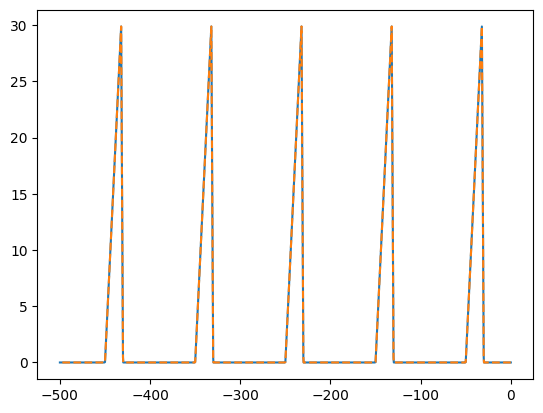

In [3]:
L_x, L_p, x2, x3, h = 500, 100, -32, -30, 30
x1 = -0.5*L_p
N_s = 1001
X0,Y0 = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)

L_p, x2, x3, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(x2, dtype=torch.float), torch.tensor(x3, dtype=torch.float), torch.tensor(h, dtype=torch.float)
X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)



print("1d X error = ", np.linalg.norm(X0 - X.cpu().numpy()))
print("1d Y error = ", np.linalg.norm(Y0 - Y.cpu().numpy()))
X_Y_numpy = X_Y.cpu().numpy()
plt.plot(X0, Y0)
plt.plot(X_Y_numpy[0, :, 0], X_Y_numpy[0, :, 1], "--")

# ##################################################
# # Prediction on a special design
# #################################################
# model = torch.load("catheter_plain_period_model_1d500", map_location=device)
# out = torch.clip(model(X_Y).squeeze(), min=0.0).detach().cpu().numpy()
# xx_mask = numpy.linspace(1.0, 0, n_periods*ncx+1) * (-L_p*n_periods)
# print("L_p, x1, x2, x3, h  = ", L_p, x1, x2, x3, h)
# print("loss = ",  -np.dot(out,xx_mask) )
# plt.figure()
# plt.plot(xx_mask, out)


(2001, 300) (7, 300) (2001, 300)
(2001, 100) (2001, 100) (2001, 100)
torch.Size([1, 2001, 3])
[ 22.           5.03923     60.09925132 -30.04962566 -11.64557141
 -15.02815168  29.89950206]
sample =  22.0
min loss =  209298.5229611952 L_p, x2, x3, h =  tensor(60.0993) tensor(-11.6456) tensor(-15.0282) tensor(29.8995)
predicted loss:  294731.001262608
predicted loss updated:  240129.38383512272
-85432.47830141264
-30830.860873927402
0.24987506246876562


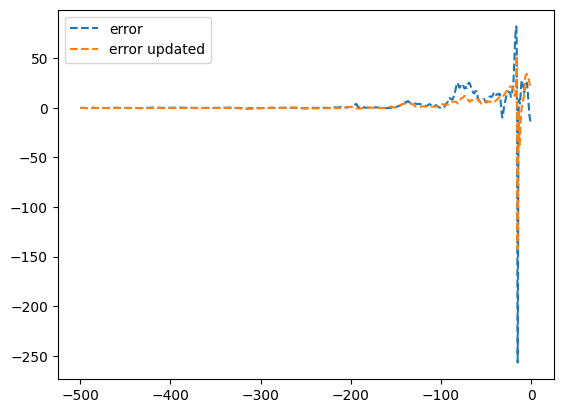

In [4]:
# All data design results
PATH = "/home/wumming/Documents/GNN-PDE/Geo-FNO-catheter/data/test/"
INPUT_X = PATH+"x_1d_structured_mesh.npy"
INPUT_Y = PATH+"y_1d_structured_mesh.npy"
INPUT_para = PATH+"data_info.npy"
OUTPUT = PATH+"density_1d_data.npy"
n_data = 3000
print(np.load(INPUT_X).shape, np.load(INPUT_para).shape, np.load(OUTPUT).shape)
inputX_raw = np.load(INPUT_X)[:, 0:n_data]
inputY_raw = np.load(INPUT_Y)[:, 0:n_data]
inputPara_raw = np.load(INPUT_para)[:, 0:n_data]
output_raw = np.load(OUTPUT)[:, 0:n_data]


# nx ny
L_x , N_s = 500.0, 2001

################################################################
# load data and data normalization
################################################################
inputX = inputX_raw[:, 0::3]
inputY = inputY_raw[:, 0::3]
inputPara = inputPara_raw[:, 0::3]
output = (output_raw[:, 0::3] + output_raw[:, 1::3] + output_raw[:, 2::3])/ 3.0
print(inputX.shape, inputY.shape, output.shape)


n_data = inputX.shape[1]
all_loss = np.zeros(n_data)


for i in range(n_data):
    
    sample, uf, L_p, x1, x2, x3, h = inputPara[:, i]
    xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
    all_loss[i] = -np.dot(output[:, i], xx_mask) * L_x/N_s

    

loss_min_ind = np.argmin(all_loss)
loss_min = all_loss[loss_min_ind]
sample, uf, L_p, x1, x2, x3, h = inputPara[:, loss_min_ind]

model = torch.load("catheter_plain_length_model_1d1000", map_location=device)
model2 = torch.load("FNO1d_updated_m12w128e400_noise_mask", map_location=device)
L_p, x2, x3, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(x2, dtype=torch.float), torch.tensor(x3, dtype=torch.float), torch.tensor(h, dtype=torch.float)

X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
out = torch.exp(model(X_Y).squeeze()).detach().cpu().numpy()
print(model2(X_Y).shape)
out2 = torch.exp(model2(X_Y)).mean(-1).squeeze().detach().cpu().numpy()


print(inputPara[:, loss_min_ind])
print("sample = ", sample)
print("min loss = ", loss_min, "L_p, x2, x3, h = ", L_p, x2, x3, h)

xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
print("predicted loss: ", -np.dot(out, xx_mask) * L_x/N_s)
print("predicted loss updated: ", -np.dot(out2, xx_mask) * L_x/N_s)

density = output[:, loss_min_ind]
mesh_X = inputX[:, loss_min_ind]
mesh_Y = inputY[:, loss_min_ind]
plt.figure()
# plt.plot(xx_mask, density, label="Reference")
plt.plot(xx_mask, out - density, "--", label="error")
plt.plot(xx_mask, out2 - density, "--", label="error updated")
# plt.plot(mesh_X, mesh_Y)
plt.legend()

print(np.dot(out - density, xx_mask) * L_x/N_s)
print(np.dot(out2 - density, xx_mask) * L_x/N_s)
print(L_x/N_s)

-27188.28157945494
-7083.468633391425
0.24987506246876562


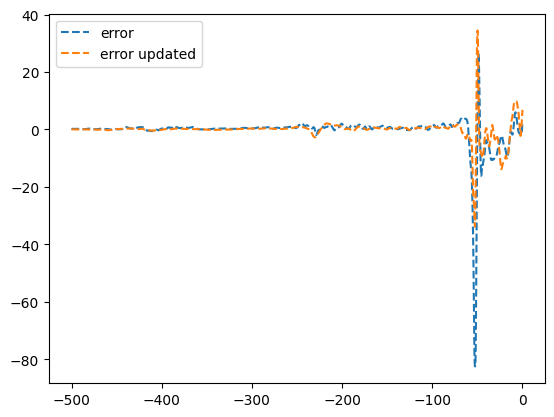

In [5]:
index = 0

sample, uf, L_p, x1, x2, x3, h = inputPara[:, index]
L_p, x2, x3, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(x2, dtype=torch.float), torch.tensor(x3, dtype=torch.float), torch.tensor(h, dtype=torch.float)
X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)

out = torch.exp(model(X_Y).squeeze()).detach().cpu().numpy()
out2 = torch.exp(model2(X_Y)).mean(-1).squeeze().detach().cpu().numpy()

density = output[:, index]
mesh_X = inputX[:, index]
mesh_Y = inputY[:, index]
plt.figure()
# plt.plot(xx_mask, density, label="Reference")
plt.plot(xx_mask, out - density, "--", label="error")
plt.plot(xx_mask, out2 - density, "--", label="error updated")
# plt.plot(mesh_X, mesh_Y)
plt.legend()

print(np.dot(out - density, xx_mask) * L_x/N_s)
print(np.dot(out2 - density, xx_mask) * L_x/N_s)
print(L_x/N_s)

# BFGS

1336001
initialize :  [ 1.32175584 -0.40546511  1.79175947  0.        ]
initialize :  (tensor(100., grad_fn=<AddBackward0>), tensor(-50., grad_fn=<MulBackward0>), tensor(-40.0000, grad_fn=<AddBackward0>), tensor(-30., grad_fn=<AddBackward0>), tensor(25., grad_fn=<AddBackward0>))
L_p, x1, x2, x3, h  =  100.0 -50.0 -40.000003814697266 -30.0 25.0


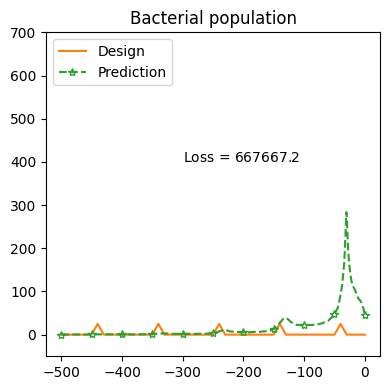

0 0.34372548000010283 loss =  644848.6875 loss_min =  inf
L_p, x1, x2, x3, h  =  68.6058349609375 -34.30291748046875 -36.65971374511719 -16.566036224365234 25.330482482910156


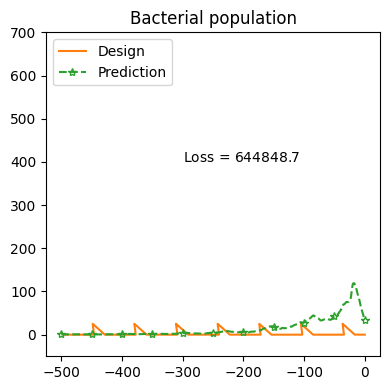

1 0.13943149399983668 loss =  656377.5625 loss_min =  644848.6875
2 0.11872671199944307 loss =  485597.34375 loss_min =  644848.6875
L_p, x1, x2, x3, h  =  83.382568359375 -41.6912841796875 -18.411483764648438 -24.03810691833496 23.30562973022461


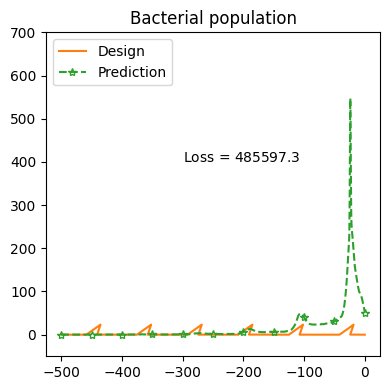

3 0.14862653100044554 loss =  659515.4375 loss_min =  485597.34375
4 0.13921218200084695 loss =  1121973.0 loss_min =  485597.34375
5 0.12603801299974293 loss =  464551.0625 loss_min =  485597.34375
L_p, x1, x2, x3, h  =  97.66374969482422 -48.83187484741211 -28.474166870117188 -26.653724670410156 26.90715789794922


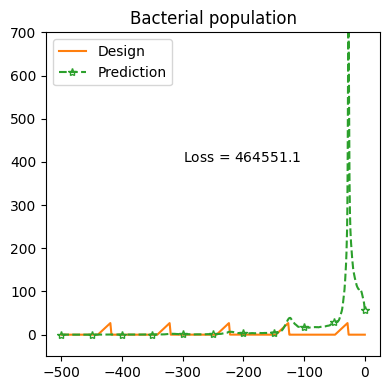

6 0.1409984470001291 loss =  1121827.125 loss_min =  464551.0625
7 0.1392899029997352 loss =  790023.6875 loss_min =  464551.0625
8 0.11919639499956247 loss =  447530.15625 loss_min =  464551.0625
L_p, x1, x2, x3, h  =  98.2982406616211 -49.14912033081055 -16.42547607421875 -29.43053436279297 28.924476623535156


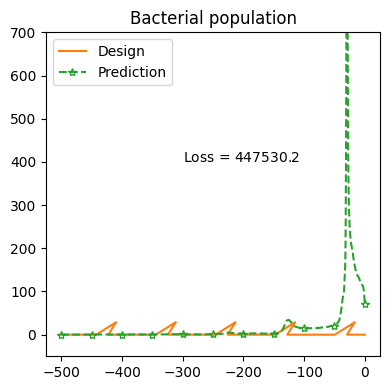

9 0.13589199400030338 loss =  376710.59375 loss_min =  447530.15625
L_p, x1, x2, x3, h  =  92.76155853271484 -46.38077926635742 -23.805343627929688 -12.682144165039062 28.64947509765625


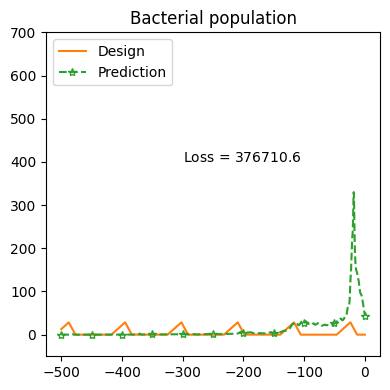

10 0.12787585800015222 loss =  420011.65625 loss_min =  376710.59375
11 0.13764762900063943 loss =  384863.78125 loss_min =  376710.59375
12 0.13151561799986666 loss =  428196.03125 loss_min =  376710.59375
13 0.13174178000008396 loss =  336670.5 loss_min =  376710.59375
L_p, x1, x2, x3, h  =  64.92662048339844 -32.46331024169922 -16.22713851928711 -7.322836875915527 29.323467254638672


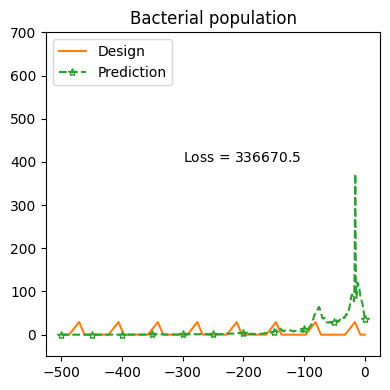

14 0.12295962600001076 loss =  763779.125 loss_min =  336670.5
15 0.11505061899970315 loss =  321739.15625 loss_min =  336670.5
L_p, x1, x2, x3, h  =  80.35086822509766 -40.17543411254883 -11.795074462890625 -18.393152236938477 29.299678802490234


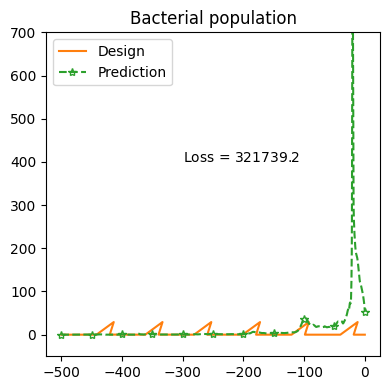

16 0.13484527499986143 loss =  545584.375 loss_min =  321739.15625
17 0.1255074170003354 loss =  376101.78125 loss_min =  321739.15625
18 0.11710779800068849 loss =  294900.65625 loss_min =  321739.15625
L_p, x1, x2, x3, h  =  65.48751831054688 -32.74375915527344 -23.372207641601562 -14.320714950561523 29.868804931640625


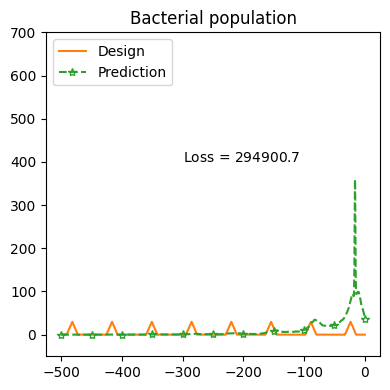

19 0.13251456600028177 loss =  519525.8125 loss_min =  294900.65625
20 0.12477964099980454 loss =  402911.71875 loss_min =  294900.65625
21 0.12783111699991423 loss =  544758.125 loss_min =  294900.65625
22 0.1291287670001111 loss =  495430.53125 loss_min =  294900.65625
23 0.12911651700051152 loss =  333661.28125 loss_min =  294900.65625
24 0.13001863499994215 loss =  276752.875 loss_min =  294900.65625
L_p, x1, x2, x3, h  =  64.31825256347656 -32.15912628173828 -21.056896209716797 -13.345678329467773 29.92727279663086


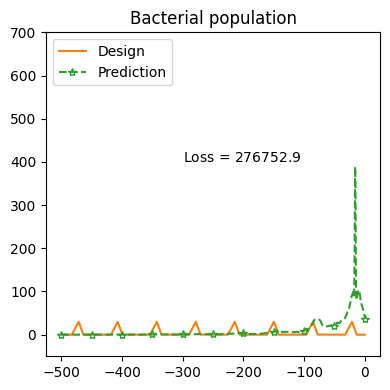

25 0.12456622999980027 loss =  366231.375 loss_min =  276752.875
26 0.12815651900018565 loss =  710279.0625 loss_min =  276752.875
27 0.12944243000038114 loss =  661994.25 loss_min =  276752.875
28 0.11764030100039236 loss =  234874.171875 loss_min =  276752.875
L_p, x1, x2, x3, h  =  62.64595031738281 -31.322975158691406 -14.023456573486328 -11.936834335327148 29.974571228027344


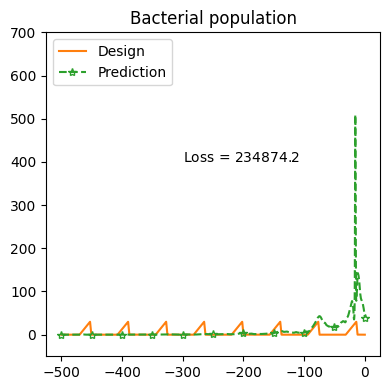

29 0.12566076899929612 loss =  273026.125 loss_min =  234874.171875
30 0.11977855999975873 loss =  256787.546875 loss_min =  234874.171875
31 0.12902296699940052 loss =  437934.875 loss_min =  234874.171875
32 0.11924769599954743 loss =  289057.90625 loss_min =  234874.171875
33 0.11614898999960133 loss =  255227.9375 loss_min =  234874.171875
34 0.1286132830000497 loss =  314786.40625 loss_min =  234874.171875
35 0.12834168999961548 loss =  508184.28125 loss_min =  234874.171875
36 0.1263515450000341 loss =  403081.6875 loss_min =  234874.171875
37 0.11816750600064552 loss =  278903.21875 loss_min =  234874.171875
38 0.07247970499975054 loss =  233281.234375 loss_min =  234874.171875
L_p, x1, x2, x3, h  =  62.29357147216797 -31.146785736083984 -4.0616912841796875 -15.413241386413574 29.933605194091797


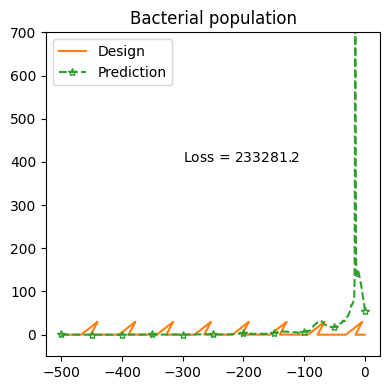

39 0.11549669400028506 loss =  255711.71875 loss_min =  233281.234375
40 0.08305175399982545 loss =  265512.84375 loss_min =  233281.234375
41 0.1315782380006567 loss =  248234.609375 loss_min =  233281.234375
42 0.08294983300038439 loss =  249807.421875 loss_min =  233281.234375
43 0.12695441999949253 loss =  242122.90625 loss_min =  233281.234375
44 0.08480791799956933 loss =  331589.875 loss_min =  233281.234375
45 0.07238207399950625 loss =  229406.234375 loss_min =  233281.234375
L_p, x1, x2, x3, h  =  63.074947357177734 -31.537473678588867 -15.556442260742188 -15.409200668334961 29.96063232421875


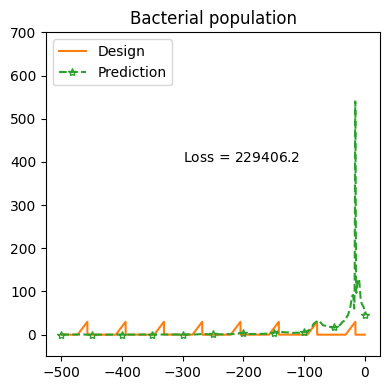

46 0.14306678400043893 loss =  577936.3125 loss_min =  229406.234375
47 0.14140256900009263 loss =  343763.6875 loss_min =  229406.234375
48 0.138555816999542 loss =  652959.0 loss_min =  229406.234375
49 0.1269855300006384 loss =  256904.578125 loss_min =  229406.234375
50 0.1289861169998403 loss =  257708.8125 loss_min =  229406.234375
51 0.08168629200008581 loss =  268390.5625 loss_min =  229406.234375
52 0.11960626900054194 loss =  265124.9375 loss_min =  229406.234375
53 0.11568097599956673 loss =  232890.75 loss_min =  229406.234375
54 0.07994089800013171 loss =  233406.96875 loss_min =  229406.234375
55 0.07568895100030204 loss =  263565.4375 loss_min =  229406.234375
56 0.11622062999958871 loss =  260976.0625 loss_min =  229406.234375
57 0.11827343699951598 loss =  297237.21875 loss_min =  229406.234375
58 0.12503039499915758 loss =  512399.15625 loss_min =  229406.234375
59 0.1272163619996718 loss =  404838.15625 loss_min =  229406.234375
60 0.1288174360006451 loss =  362029.6

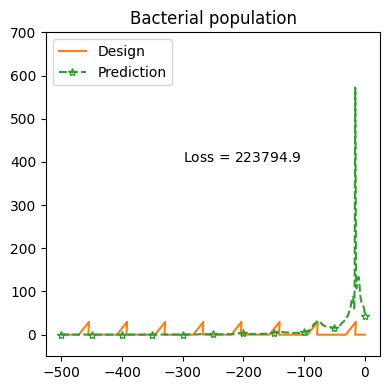

66 0.06995798399930209 loss =  322003.4375 loss_min =  223794.90625
67 0.11043366200010496 loss =  290883.1875 loss_min =  223794.90625
68 0.0634654599998612 loss =  230319.859375 loss_min =  223794.90625
69 0.07885932799945294 loss =  256676.671875 loss_min =  223794.90625
70 0.06256914100049471 loss =  291990.1875 loss_min =  223794.90625
71 0.07318766000025789 loss =  292591.40625 loss_min =  223794.90625
72 0.07289200800005347 loss =  274120.1875 loss_min =  223794.90625
73 0.07017464600085077 loss =  278863.84375 loss_min =  223794.90625
74 0.07422021999991557 loss =  287564.09375 loss_min =  223794.90625
75 0.1211384710004495 loss =  395126.71875 loss_min =  223794.90625
76 0.06479303099968092 loss =  262773.15625 loss_min =  223794.90625
77 0.057140086999424966 loss =  237120.0625 loss_min =  223794.90625
78 0.06306489600046916 loss =  236516.453125 loss_min =  223794.90625
79 0.07598314400001982 loss =  239293.984375 loss_min =  223794.90625
80 0.07371056600004522 loss =  38208

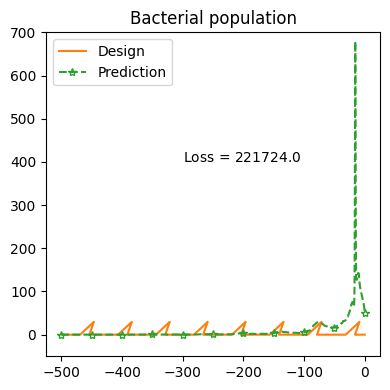

102 0.12221014999977342 loss =  235321.421875 loss_min =  221723.984375
103 0.08339291599986609 loss =  262885.375 loss_min =  221723.984375
104 0.11414052300006006 loss =  368782.125 loss_min =  221723.984375
105 0.1271565710003415 loss =  240459.71875 loss_min =  221723.984375
106 0.11930506699991383 loss =  224705.25 loss_min =  221723.984375
107 0.11738160000004427 loss =  224144.125 loss_min =  221723.984375
108 0.062330710000424006 loss =  231060.640625 loss_min =  221723.984375
109 0.06279364500005613 loss =  239961.140625 loss_min =  221723.984375
110 0.07305551999979798 loss =  308150.0625 loss_min =  221723.984375
111 0.1058901540000079 loss =  241909.96875 loss_min =  221723.984375
112 0.07325769100043544 loss =  263647.8125 loss_min =  221723.984375
113 0.05497420899973804 loss =  257024.0 loss_min =  221723.984375
114 0.06430132599962235 loss =  247240.21875 loss_min =  221723.984375
115 0.05617246899964812 loss =  284223.09375 loss_min =  221723.984375
116 0.0561386580002

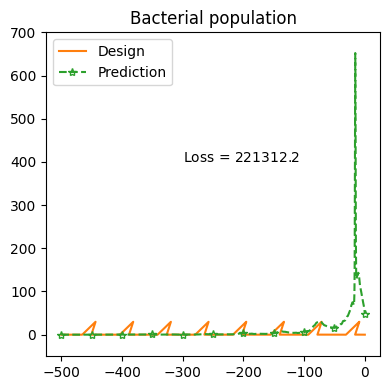

124 0.0657970899992506 loss =  455780.6875 loss_min =  221312.203125
125 0.054814907999571005 loss =  236295.03125 loss_min =  221312.203125
126 0.06406214500020724 loss =  317643.25 loss_min =  221312.203125
127 0.06451766899954237 loss =  279372.1875 loss_min =  221312.203125
128 0.05531023200001073 loss =  256050.453125 loss_min =  221312.203125
129 0.057859151999764435 loss =  242719.953125 loss_min =  221312.203125
130 0.059941129999970144 loss =  280027.09375 loss_min =  221312.203125
131 0.05247477800003253 loss =  314572.03125 loss_min =  221312.203125
132 0.05078223300006357 loss =  229357.640625 loss_min =  221312.203125
133 0.06660841600023559 loss =  232454.375 loss_min =  221312.203125
134 0.07285786899956292 loss =  257845.046875 loss_min =  221312.203125
135 0.07529499799966288 loss =  326834.09375 loss_min =  221312.203125
136 0.060367523999957484 loss =  267900.03125 loss_min =  221312.203125
137 0.04639916700034519 loss =  234976.78125 loss_min =  221312.203125
138 0.

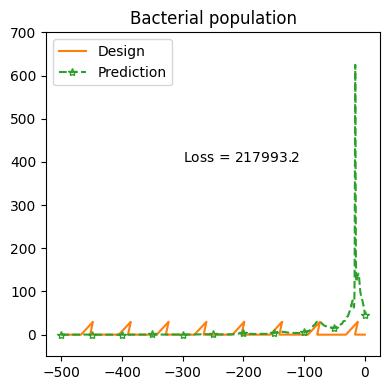

160 0.033839983000689244 loss =  227390.96875 loss_min =  217993.25
161 0.0481106320003164 loss =  229482.890625 loss_min =  217993.25
162 0.053354365999439324 loss =  312066.5 loss_min =  217993.25
163 0.047679358999630495 loss =  253674.96875 loss_min =  217993.25
164 0.05973250899933191 loss =  228205.625 loss_min =  217993.25
165 0.0485169350004071 loss =  231103.875 loss_min =  217993.25
166 0.04798994100019627 loss =  231121.265625 loss_min =  217993.25
167 0.03886261500065302 loss =  304906.5625 loss_min =  217993.25
168 0.046601998999904026 loss =  221516.96875 loss_min =  217993.25
169 0.041029361999790126 loss =  263572.65625 loss_min =  217993.25
170 0.04652814899964142 loss =  274837.875 loss_min =  217993.25
171 0.03824044000066351 loss =  291761.0 loss_min =  217993.25
172 0.038058067999372724 loss =  243018.703125 loss_min =  217993.25
173 0.03871153299951402 loss =  302529.8125 loss_min =  217993.25
174 0.04204665100041893 loss =  292234.5625 loss_min =  217993.25
175 0

In [6]:
################################################################
# inverse optimization for 1d
################################################################
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

model = torch.load("catheter_plain_length_model_1d1000", map_location=device)
print(count_params(model))


epochs = 250

# constraints   
#               60 < L_p < 250
#               x1 = -0.5L_p 
#               
#               15 < x3 - x1 < L_p/2
#             -L_p < x2      < 0
#               20 < h       < 30
# def transfer(theta):
def transfer(theta):
    
    L_p = 60 + (250 - 60)/(1 + torch.exp(theta[0]))
    x1 = -0.5*L_p
    x3 = x1  + 15 + (L_p/2 - 15)/(1 + torch.exp(theta[2]))
    x2 = -L_p  + L_p/(1 + torch.exp(theta[1]))
    h = 20   + (10)/(1 + torch.exp(theta[3]))
    return L_p, x1, x2, x3, h


def inv_transfer(L_p, x2, x3, h):
    x1 = -0.5*L_p
    theta = np.zeros(4)
    theta[0] = np.log( (250 - 60)/(L_p - 60) - 1 )
    theta[1] = np.log( L_p/(x2 + L_p) - 1 )
    theta[2] = np.log( (L_p/2 - 15)/(x3 - x1  - 15) - 1 )
    theta[3] = np.log( 10/(h - 20 ) - 1 )
    return theta

# sample, uf, L_p, x1, x2, x3, h = inputPara[:, loss_min_ind]
# L_p, x2, x3, h = 80.0, -22.0, -22.0, 28.0
L_p, x2, x3, h = 100.0, -40.0, -30.0, 25.0
# L_p, x2, x3, h = 61.0, -30.0, -12.5, 29.0
# x2, x3, h = 73.85438537597656, -9.479606628417969, -19.35201644897461, 27.60188102722168
theta0 =  inv_transfer(L_p, x2, x3, h) 
print("initialize : ", theta0)

theta = torch.tensor(theta0.astype(np.float32) , requires_grad=True)
print("initialize : ", transfer(theta))

bacteria_pred = []
L_x = 500
N_s = 2001
xx_mask = (torch.linspace(1.0, 0, N_s) * (-L_x)).to(device)

max_iter = 100

optimizer = torch.optim.LBFGS([theta], max_iter=max_iter, lr=1.0, line_search_fn="strong_wolfe")

loss_min = torch.tensor(np.inf)

loss_all = []
theta_min = torch.clone(theta)

def saveplot(theta, out, savefig_name):
    bacteria_pred.append(out)
    L_p, x1, x2, x3, h = transfer(theta)
    mesh = x.detach().cpu().numpy()
    
    current_loss = (-torch.sum(torch.matmul(out, xx_mask))* L_x/N_s).item()
    
    print("L_p, x1, x2, x3, h  = ", L_p.item(), x1.item(), x2.item(), x3.item(), h.item())
    plt.figure(figsize=(4,4))
    plt.title("Bacterial population")
    plt.plot(mesh[0, :, 0], mesh[0, :, 1], color="C1", label="Design")
    plt.plot(xx_mask.detach().cpu().numpy(), out.detach().cpu().numpy().T, "--*", color="C2", fillstyle='none', markevery=len(xx_mask)//10, label="Prediction")
    
    plt.legend(loc="upper left")
    plt.ylim([-50,700])
    
    plt.text(-300,400,"Loss = "+r"$%3.1f$" %current_loss,\
          bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1})
    
    
    plt.tight_layout()
    plt.savefig(savefig_name)
    plt.show()
    
plot_id = 0

# first_figure
L_p, x1, x2, x3, h = transfer(theta)  
x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
out = torch.exp(model(x).squeeze())
saveplot(theta, out, "movie/design_iter" + str(plot_id).zfill(4) + ".png")
plot_id += 1

for ep in range(epochs):
    t1 = default_timer()
    def loss_closure():
        
        L_p, x1, x2, x3, h = transfer(theta)
        
        x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
    
        optimizer.zero_grad()
        out = torch.exp(model(x).squeeze())
        loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
        loss.backward()
        loss_all.append(loss.item())
        return loss
    
    
    optimizer.step(loss_closure)

    t2 = default_timer()
 
    if ep%1==0:
        
        L_p, x1, x2, x3, h = transfer(theta)
        x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
        out = torch.exp(model(x).squeeze())
        loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
        print(ep, t2 - t1,  "loss = ", loss.item(), "loss_min = ", loss_min.item(),)
 
        if loss < loss_min:
            
            theta_min = torch.clone(theta)
            loss_min = loss
            
            
            saveplot(theta, out, "movie/design_iter"+ str(plot_id).zfill(4)+".png")
            plot_id += 1
            
        theta = theta_min + torch.normal(mean=0.0, std=torch.ones(len(theta)))

1018883
initialize :  [ 1.32175584 -0.40546511  1.79175947  0.        ]
initialize :  (tensor(100., grad_fn=<AddBackward0>), tensor(-50., grad_fn=<MulBackward0>), tensor(-40.0000, grad_fn=<AddBackward0>), tensor(-30., grad_fn=<AddBackward0>), tensor(25., grad_fn=<AddBackward0>))
L_p, x1, x2, x3, h  =  100.0 -50.0 -40.000003814697266 -30.0 25.0


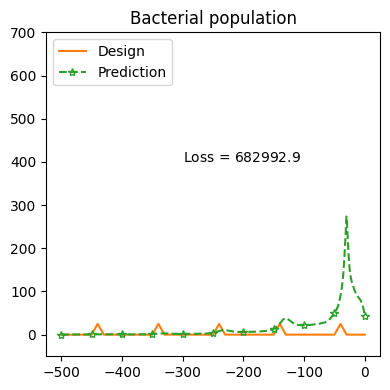

0 0.15531807700062927 loss =  662958.25 loss_min =  inf
L_p, x1, x2, x3, h  =  83.07015991210938 -41.53507995605469 -38.540565490722656 -22.927444458007812 25.060440063476562


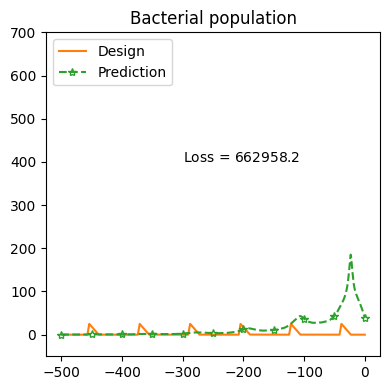

/tmp/ipykernel_5417/1967595154.py:98: RuntimeWarning: divide by zero encountered in log
  theta = theta_min + torch.normal(mean=0.0, std=torch.ones(len(theta))) * 10/(np.log(ep)+1)


1 0.1878627679998317 loss =  662958.25 loss_min =  662958.25
2 0.12088996900001803 loss =  1713920.0 loss_min =  662958.25
3 0.17497754099986196 loss =  527697.6875 loss_min =  662958.25
L_p, x1, x2, x3, h  =  232.19288635253906 -116.09644317626953 -17.184722900390625 -15.954994201660156 22.590408325195312


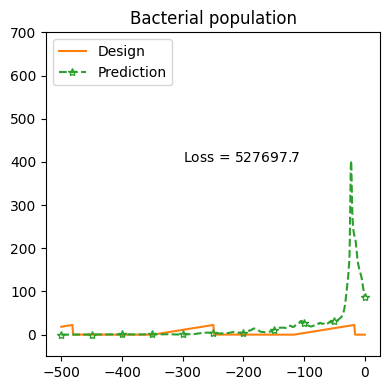

4 0.10182916000030673 loss =  2893980.25 loss_min =  527697.6875
5 0.19907586200042715 loss =  536393.3125 loss_min =  527697.6875
6 0.19759932900069543 loss =  2413517.25 loss_min =  527697.6875
7 0.09888786600004096 loss =  2105193.5 loss_min =  527697.6875
8 0.18702671099981671 loss =  1290630.125 loss_min =  527697.6875
9 0.19396041800064268 loss =  1135275.875 loss_min =  527697.6875
10 0.18941785100014386 loss =  865498.0 loss_min =  527697.6875
11 0.1758272280003439 loss =  451776.4375 loss_min =  527697.6875
L_p, x1, x2, x3, h  =  234.07228088378906 -117.03614044189453 -37.57666015625 -15.796188354492188 28.47879981994629


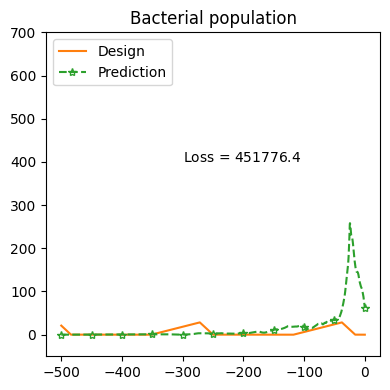

12 0.1899349559998882 loss =  527219.75 loss_min =  451776.4375
13 0.1165692439999475 loss =  256328.5 loss_min =  451776.4375
L_p, x1, x2, x3, h  =  65.50009155273438 -32.75004577636719 -9.648460388183594 -3.1922731399536133 29.80487632751465


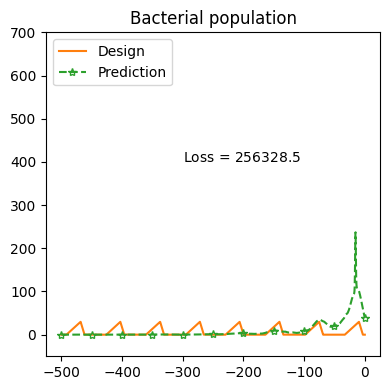

14 0.20432571600031224 loss =  942201.0625 loss_min =  256328.5
15 0.2651894339996943 loss =  1287967.0 loss_min =  256328.5
16 0.22796707300039998 loss =  535469.25 loss_min =  256328.5
17 0.27676654100014275 loss =  489758.375 loss_min =  256328.5
18 0.22775799100054428 loss =  608758.1875 loss_min =  256328.5
19 0.2734802229997513 loss =  1304700.125 loss_min =  256328.5
20 0.21943162200022925 loss =  292390.0 loss_min =  256328.5
21 0.22967720799988456 loss =  562168.625 loss_min =  256328.5
22 0.24423443900013808 loss =  556388.4375 loss_min =  256328.5
23 0.2458603420000145 loss =  473600.90625 loss_min =  256328.5
24 0.22561537399997178 loss =  259024.953125 loss_min =  256328.5
25 0.21920644999954675 loss =  282135.59375 loss_min =  256328.5
26 0.20400084399989282 loss =  893431.875 loss_min =  256328.5
27 0.2297771779994946 loss =  1578061.75 loss_min =  256328.5
28 0.22944211499998346 loss =  282081.34375 loss_min =  256328.5
29 0.22801581299972895 loss =  357928.0625 loss_mi

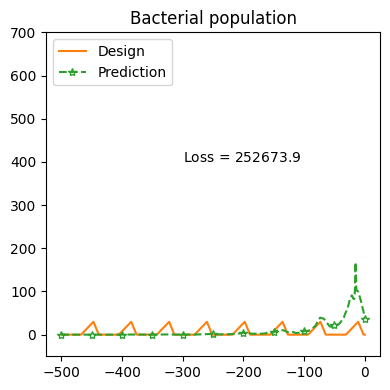

34 0.23951420999947004 loss =  685564.1875 loss_min =  252673.9375
35 0.20398334199944657 loss =  755825.9375 loss_min =  252673.9375
36 0.23570165799992537 loss =  563859.5 loss_min =  252673.9375
37 0.22730301799947483 loss =  290837.21875 loss_min =  252673.9375
38 0.20660770499944192 loss =  261945.578125 loss_min =  252673.9375
39 0.21006048399976862 loss =  289839.375 loss_min =  252673.9375
40 0.2142901189999975 loss =  451162.125 loss_min =  252673.9375
41 0.24824260199966375 loss =  861889.5625 loss_min =  252673.9375
42 0.11694608600009815 loss =  277506.875 loss_min =  252673.9375
43 0.21733699399919715 loss =  245710.28125 loss_min =  252673.9375
L_p, x1, x2, x3, h  =  60.200218200683594 -30.100109100341797 -13.565799713134766 -6.0697736740112305 29.839534759521484


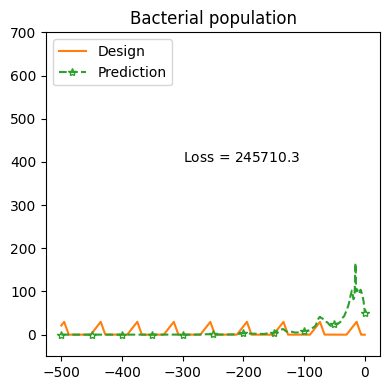

44 0.2460261440000977 loss =  313486.75 loss_min =  245710.28125
45 0.21873824600061198 loss =  738954.3125 loss_min =  245710.28125
46 0.22193775300002017 loss =  843659.9375 loss_min =  245710.28125
47 0.2344635070003278 loss =  507648.375 loss_min =  245710.28125
48 0.21982915500029776 loss =  830205.0 loss_min =  245710.28125
49 0.23108013899945945 loss =  255223.171875 loss_min =  245710.28125
50 0.11587281699939922 loss =  274253.375 loss_min =  245710.28125
51 0.24031129600007262 loss =  257213.796875 loss_min =  245710.28125
52 0.12172279700007493 loss =  262151.625 loss_min =  245710.28125
53 0.20465279899963207 loss =  264297.4375 loss_min =  245710.28125
54 0.2077681640002993 loss =  251192.875 loss_min =  245710.28125
55 0.2245659150003121 loss =  292518.9375 loss_min =  245710.28125
56 0.2277548209995075 loss =  304924.375 loss_min =  245710.28125
57 0.21645578700008627 loss =  377496.5 loss_min =  245710.28125
58 0.22601230700001906 loss =  865053.5625 loss_min =  245710.

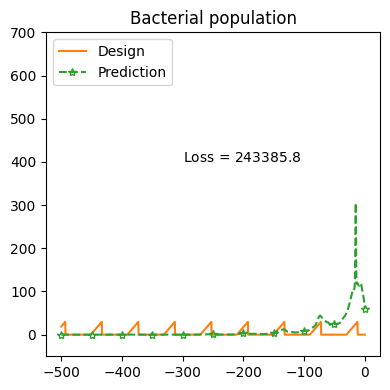

66 0.21613427400006913 loss =  419421.875 loss_min =  243385.8125
67 0.12220208999951865 loss =  246772.59375 loss_min =  243385.8125
68 0.19519993999983853 loss =  245982.375 loss_min =  243385.8125
69 0.20438998600002378 loss =  255272.921875 loss_min =  243385.8125
70 0.19301151200033928 loss =  274015.0625 loss_min =  243385.8125
71 0.21915518999958294 loss =  372663.4375 loss_min =  243385.8125
72 0.21975598500011984 loss =  312165.90625 loss_min =  243385.8125
73 0.19649458900039463 loss =  250840.25 loss_min =  243385.8125
74 0.2132435200001055 loss =  284722.03125 loss_min =  243385.8125
75 0.23218540900052176 loss =  504952.46875 loss_min =  243385.8125
76 0.2149983550007164 loss =  262988.5 loss_min =  243385.8125
77 0.20959227999992436 loss =  255168.578125 loss_min =  243385.8125
78 0.21561702999952104 loss =  307470.9375 loss_min =  243385.8125
79 0.20442080599968904 loss =  282895.28125 loss_min =  243385.8125
80 0.2357654889992773 loss =  690892.875 loss_min =  243385.81

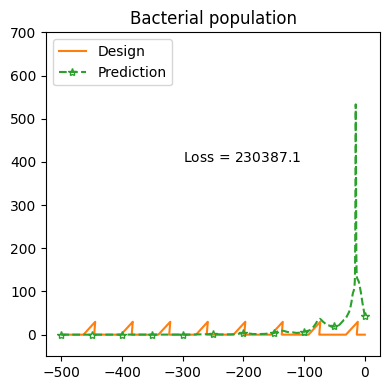

87 0.21334546099933505 loss =  249799.4375 loss_min =  230387.0625
88 0.21503505500004394 loss =  273344.65625 loss_min =  230387.0625
89 0.22932633500022348 loss =  265265.71875 loss_min =  230387.0625
90 0.24452228099926288 loss =  674548.3125 loss_min =  230387.0625
91 0.22882987999946636 loss =  368637.1875 loss_min =  230387.0625
92 0.22502459800034558 loss =  234841.765625 loss_min =  230387.0625
93 0.23662368500026787 loss =  233290.703125 loss_min =  230387.0625
94 0.11741615000028105 loss =  276965.28125 loss_min =  230387.0625
95 0.21365306400002737 loss =  243190.09375 loss_min =  230387.0625
96 0.2181834009998056 loss =  260522.890625 loss_min =  230387.0625
97 0.20830417900015163 loss =  254998.28125 loss_min =  230387.0625
98 0.19574211399958585 loss =  256300.8125 loss_min =  230387.0625
99 0.21823463199962134 loss =  369346.09375 loss_min =  230387.0625
100 0.19370005700056936 loss =  274548.90625 loss_min =  230387.0625
101 0.11268768100035231 loss =  240105.640625 los

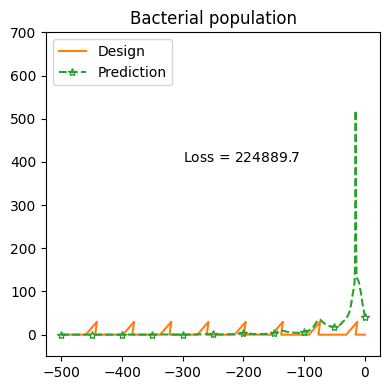

124 0.15774336699996638 loss =  951750.25 loss_min =  224889.734375
125 0.07729190500049299 loss =  250101.40625 loss_min =  224889.734375
126 0.09069907699995383 loss =  330229.875 loss_min =  224889.734375
127 0.09166413599996304 loss =  235685.078125 loss_min =  224889.734375
128 0.10143004600013228 loss =  275983.6875 loss_min =  224889.734375
129 0.07762457799981348 loss =  251467.71875 loss_min =  224889.734375
130 0.09034828500080039 loss =  260128.03125 loss_min =  224889.734375
131 0.16441619299985177 loss =  688940.25 loss_min =  224889.734375
132 0.11600013899987971 loss =  264155.4375 loss_min =  224889.734375
133 0.16640871900017373 loss =  360693.71875 loss_min =  224889.734375
134 0.16838694600028248 loss =  445315.3125 loss_min =  224889.734375
135 0.07715633400039223 loss =  245193.1875 loss_min =  224889.734375
136 0.08947726699989289 loss =  251477.359375 loss_min =  224889.734375
137 0.08772698200027662 loss =  250059.171875 loss_min =  224889.734375
138 0.092959406

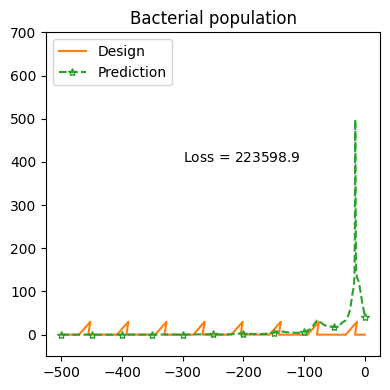

231 0.06697800899928552 loss =  377620.34375 loss_min =  223598.9375
232 0.05398057999991579 loss =  234599.4375 loss_min =  223598.9375
233 0.07035475800057611 loss =  247942.34375 loss_min =  223598.9375
234 0.042631186000107846 loss =  247721.140625 loss_min =  223598.9375
235 0.06505478299914103 loss =  237518.15625 loss_min =  223598.9375
236 0.07294548000027135 loss =  333810.21875 loss_min =  223598.9375
237 0.0734919140004422 loss =  297925.84375 loss_min =  223598.9375
238 0.0792931320002026 loss =  272706.6875 loss_min =  223598.9375
239 0.08449972600010369 loss =  336618.59375 loss_min =  223598.9375
240 0.07626648599944019 loss =  318862.40625 loss_min =  223598.9375
241 0.07693296300021757 loss =  252888.796875 loss_min =  223598.9375
242 0.07496619599987753 loss =  241276.125 loss_min =  223598.9375
243 0.09342321999974956 loss =  264764.5 loss_min =  223598.9375
244 0.1253312860008009 loss =  923179.5 loss_min =  223598.9375
245 0.11513563100015745 loss =  255413.71875 l

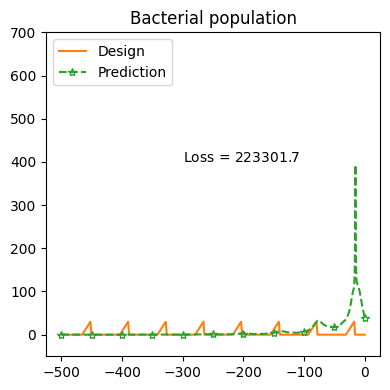

In [7]:
################################################################
# inverse optimization for 1d
################################################################
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

model = torch.load("FNO1d_updated_m12w128e400_noise_mask", map_location=device)
print(count_params(model))


epochs = 250

# constraints   
#               60 < L_p < 250
#               x1 = -0.5L_p 
#               
#               15 < x3 - x1 < L_p/2
#             -L_p < x2      < 0
#               20 < h       < 30
# def transfer(theta):


# sample, uf, L_p, x1, x2, x3, h = inputPara[:, loss_min_ind]
# L_p, x2, x3, h = 80.0, -22.0, -22.0, 28.0
L_p, x2, x3, h = 100.0, -40.0, -30.0, 25.0
# L_p, x2, x3, h = 61.0, -30.0, -12.5, 29.0
# x2, x3, h = 73.85438537597656, -9.479606628417969, -19.35201644897461, 27.60188102722168
theta0 =  inv_transfer(L_p, x2, x3, h) 
print("initialize : ", theta0)

theta = torch.tensor(theta0.astype(np.float32) , requires_grad=True)
print("initialize : ", transfer(theta))

bacteria_pred = []
L_x = 500
N_s = 2001
xx_mask = (torch.linspace(1.0, 0, N_s) * (-L_x)).to(device)

max_iter = 100

optimizer = torch.optim.LBFGS([theta], max_iter=max_iter, lr=1, line_search_fn="strong_wolfe")

loss_min = torch.tensor(np.inf)

loss_all = []
loss_all_min = []
theta_min = torch.clone(theta)

plot_id = 0

# first_figure
L_p, x1, x2, x3, h = transfer(theta)  
x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
out = torch.exp(model(x)).mean(-1).squeeze()
saveplot(theta, out, "movie/design_iter" + str(plot_id).zfill(4) + ".png")
plot_id += 1

for ep in range(epochs):
    t1 = default_timer()
    def loss_closure():
        
        L_p, x1, x2, x3, h = transfer(theta)
        
        x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
    
        optimizer.zero_grad()
        out = torch.exp(model(x)).mean(-1).squeeze()
        loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
        loss.backward()
        loss_all.append(loss.item())
        loss_all_min.append(loss_min)
        return loss
    
    
    optimizer.step(loss_closure)

    t2 = default_timer()
 
    if ep%1==0:
        
        L_p, x1, x2, x3, h = transfer(theta)
        x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
        out = torch.exp(model(x)).mean(-1).squeeze()
        loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
        print(ep, t2 - t1,  "loss = ", loss.item(), "loss_min = ", loss_min.item(),)
 
        if loss < loss_min:
            
            theta_min = torch.clone(theta)
            loss_min = loss
            
            
            saveplot(theta, out, "movie/design_iter"+ str(plot_id).zfill(4)+".png")
            plot_id += 1
            
        theta = theta_min + torch.normal(mean=0.0, std=torch.ones(len(theta))) * 10/(np.log(ep)+1)

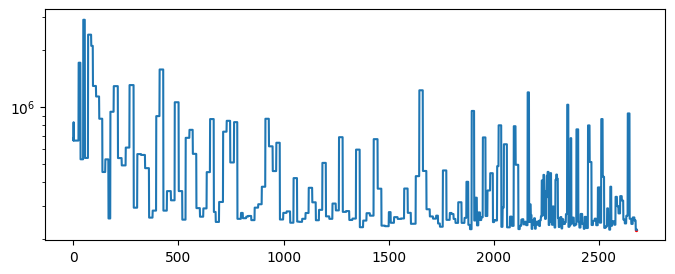

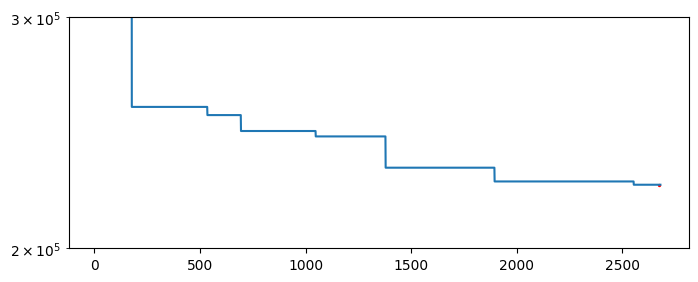

In [8]:
fig = plt.figure(figsize=(8,3))
plt.semilogy(loss_all, "-", markersize=1)
minind = np.array(loss_all).argmin()
plt.scatter(minind, loss_all[minind], color="red", s=2)
fig.savefig("optimization-loss.pdf")

loss_all_min_cpu = [l.cpu().detach().numpy() for l in loss_all_min]
fig = plt.figure(figsize=(8,3))
plt.semilogy(loss_all_min_cpu, "-", markersize=1)
plt.ylim(200000, 300000)

minind = np.array(loss_all).argmin()
plt.scatter(minind, loss_all[minind], color="red", s=2)
fig.savefig("optimization-loss.pdf")

1570

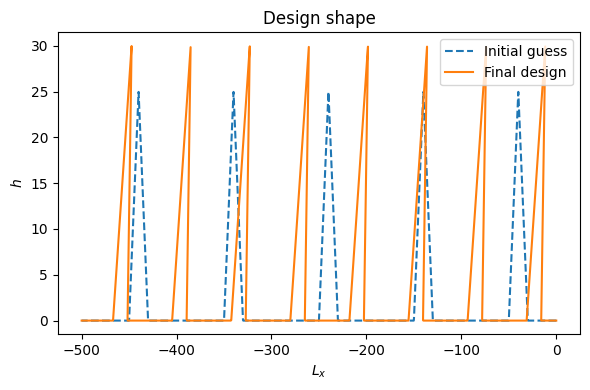

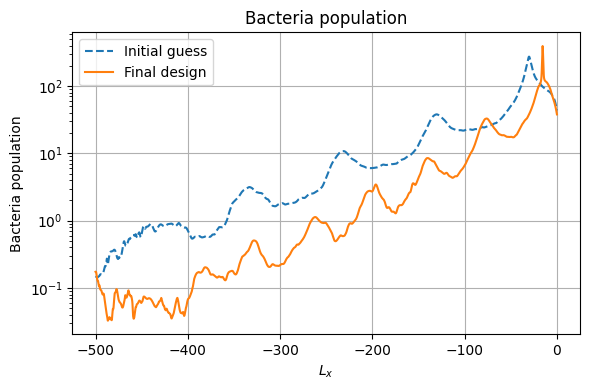

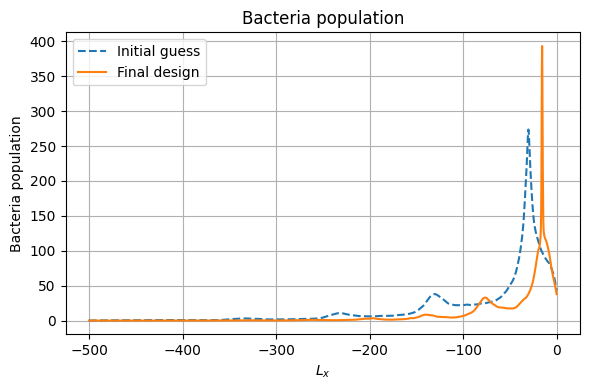

In [9]:
# Draw initial guess and final designs 

L_x, L_p, x2, x3, h = 500, 100.0, -40.0, -30.0, 25.0
x1 = -0.5*L_p
N_s = 2001
X0,Y0 = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)
plt.figure(figsize=(6, 4))
plt.plot(X0, Y0, "--", label="Initial guess")
L_p, x1, x2, x3, h = 62.2564697265625,  -31.12823486328125, -11.565677642822266, -15.864848136901855, 29.99827766418457
x1 = -0.5*L_p
N_s = 2001
X0,Y0 = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)
plt.plot(X0, Y0, label="Final design")
plt.legend()
plt.title("Design shape")
plt.ylabel("$h$")
plt.xlabel("$L_x$")
plt.tight_layout()
plt.savefig("design.png")


xx_mask = np.linspace(1.0, 0, N_s) * (-L_x)
#######################################################################
plt.figure(figsize=(6, 4))
plt.plot(xx_mask, bacteria_pred[0].detach().cpu().numpy(), "--", label="Initial guess")
plt.semilogy(xx_mask, bacteria_pred[-1].detach().cpu().numpy(), label="Final design")
plt.legend()
plt.title("Bacteria population")
plt.grid("on")
plt.ylabel("Bacteria population")
plt.xlabel("$L_x$")
plt.tight_layout()
plt.savefig("bacteria_population_semilogy.png")


#######################################################################
plt.figure(figsize=(6, 4))
plt.plot(xx_mask, bacteria_pred[0].detach().cpu().numpy(), "--", label="Initial guess")
plt.plot(xx_mask, bacteria_pred[-1].detach().cpu().numpy(), label="Final design")
plt.legend()
plt.title("Bacteria population")
plt.grid("on")
plt.ylabel("Bacteria population")
plt.xlabel("$L_x$")
plt.tight_layout()
plt.savefig("bacteria_population.png")

fno_loss =  224575.9375 ref_loss =  -0.0


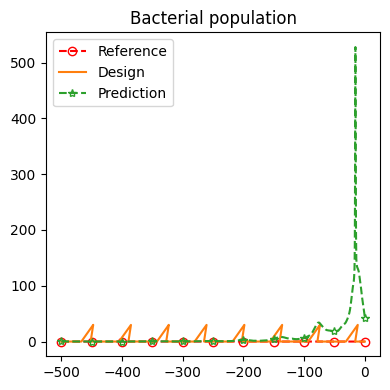

In [10]:
import glob
# Design validation

train_data_folder = "data"
t = 9


N_s, L_x = 2001, 500
bw_method = 1e-1
xx = np.linspace(-L_x, 0.0, N_s)
xx_mask = (torch.linspace(1.0, 0, N_s) * (-L_x)).to(device)

samples = [0]
x_mesh, y_mesh = np.zeros((len(samples), N_s)), np.zeros((len(samples), N_s))
density_1d_data_all = np.zeros((len(samples), N_s, 3))
density_1d_data = np.zeros((len(samples), N_s))
L_p, x1, x2, x3, h = 62.2564697265625,  -31.12823486328125, -11.565677642822266, -15.864848136901855, 29.99827766418457
# L_p, x1, x2, x3, h = 62.32211685180664, -31.16105842590332, -11.533348083496094, -16.148033142089844, 29.966632843017578

for i in range(len(samples)):
    
    x_mesh[i,:], y_mesh[i,:] = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)
    
    file_names = glob.glob(train_data_folder+"/tri*")
    for file_name in file_names:
        
        print(file_name)
        uf  = np.float64(  file_name[file_name.find("uf") + len("uf"):  file_name.find("alpha")]  )
        # sample is from 1 - 1000
        j = 0
        if uf < (5.0 + 10.0)/2:
            j = 0
        elif uf < (10. + 15.0)/2:
            j = 1
        elif uf < (15. + 20.0)/2:
            j = 2
        else:
            print("error! uf = ", uf)
            
        
        # preprocee density
        hf = h5py.File(file_name, "r")
        x_b = hf["config"][str(t+1)]["x"][:]
        y_b = hf["config"][str(t+1)]["y"][:]

        if(min(x_b) < -L_x):
            print("warning: bacteria out of the domain. file_name = ", file_name, " loc = ", min(x_b), " end point = ", -L_x)

        

        bacteria_1d_data = x_b[np.logical_and(x_b <= 0 , x_b >= -L_x)]
        n_particle = len(bacteria_1d_data)
        kernel = stats.gaussian_kde(bacteria_1d_data, bw_method = bw_method)
        density_1d_data_all[i, :, j] = kernel(xx)*n_particle
    
    density_1d_data[i, :] = np.mean(density_1d_data_all[i, :, :], axis=1)

    plt.figure(figsize=(4,4))
    plt.plot(xx,  density_1d_data[i, :], "--o", color="red", markevery=len(xx_mask)//10, fillstyle='none', label="Reference")
    plt.plot(x_mesh[i, :], y_mesh[i, :], color="C1", label="Design")
    
    ref_loss = -np.sum(np.matmul(density_1d_data[i, :], xx))* L_x/N_s
    

    x, XC, YC = catheter_mesh_1d_total_length(L_x, torch.tensor(L_p), torch.tensor(x2), torch.tensor(x3), h, N_s)
    out = torch.exp(model(x)).mean(-1).squeeze()
    fno_loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
    print("fno_loss = ", fno_loss.item(), "ref_loss = ", ref_loss)
        
    plt.plot(xx_mask.detach().cpu().numpy(), out.detach().cpu().numpy().T, "--*", color="C2", fillstyle='none', markevery=len(xx_mask)//10, label="Prediction")
    plt.legend()
    plt.title("Bacterial population")
    plt.tight_layout()
    plt.savefig("Design_tri.pdf")



# Plot 

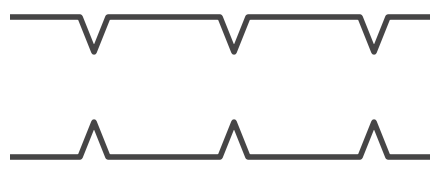

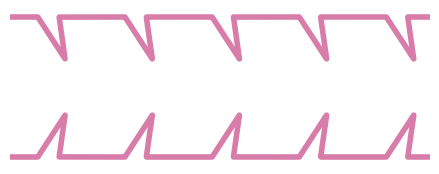

In [25]:
# Draw initial guess and final designs 

L_x, L_p, x2, x3, h = 500, 100.0, -40.0, -30.0, 25.0
x1 = -0.5*L_p
N_s = 2001
X0,Y0 = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)
plt.figure(figsize=(6, 2))
plt.plot(X0, 100-Y0, color="#464546", linewidth=4.0)
plt.plot(X0, Y0, color="#464546", linewidth=4.0)
plt.axis('off'),
plt.xlim([-300, 0])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.savefig("initial_guess.pdf")

L_p, x1, x2, x3, h = 62.2564697265625,  -31.12823486328125, -11.565677642822266, -15.864848136901855, 29.99827766418457
x1 = -0.5*L_p
N_s = 2001
X0,Y0 = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)
plt.figure(figsize=(6, 2))
plt.plot(X0, 100-Y0, color="#D87CA9", linewidth=4.0)
plt.plot(X0, Y0, color="#D87CA9", linewidth=4.0)
plt.axis('off'),
plt.xlim([-300, 0])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.savefig("final_guess.pdf")
# plt.title("Design shape")
# plt.ylabel("$h$")
# plt.xlabel("$L_x$")
# plt.savefig("design.png")




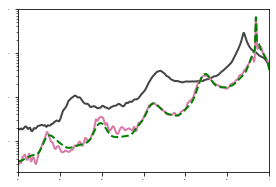

In [37]:
xx_mask = np.linspace(1.0, 0, N_s) * (-L_x)
#######################################################################
plt.figure(figsize=(4.5, 3))
plt.plot(xx_mask, bacteria_pred[0].detach().cpu().numpy(), color="#464546", linewidth=2.0, label="initial design")
plt.semilogy(xx_mask, bacteria_pred[-1].detach().cpu().numpy(), color="#D87CA9", linewidth=2.0, label="optimized design")
plt.semilogy(xx_mask, density_1d_data[i, :], "--",  color="green", linewidth=2.0)

plt.xlim([-300, 0])
plt.ylim([0.2, 1e3])
#plt.grid(linestyle='--', linewidth=0.5)


# plt.legend(loc = "upper center",bbox_to_anchor=(0.5,1.15),ncol=2)
# plt.tight_layout()
plt.tick_params(labelsize=0) 
# plt.yticks(labelsize=0) 
plt.savefig("bacteria_population_semilogy.pdf")




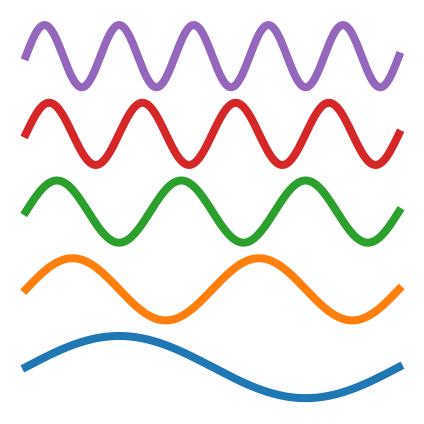

In [54]:
# Draw Fourier basis functions

xx = np.linspace(0, 1, 1001)

plt.figure(figsize=(6, 6))
dy = 2.5
shift = 0
for i in range(5):
    plt.plot(xx, np.sin(2*np.pi*(i+1)*xx)+shift*dy, color="C"+str(i),  linewidth=8.0)
    shift += 1.0
#     plt.plot(xx, np.cos(2*np.pi*(2*i+2)*xx)+shift*dy,   linewidth=4.0)
#     shift += 1.0
plt.axis('off'),
# ax = plt.gca()
# # ax.set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig("Fourier_basis_functions.pdf")



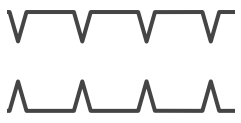

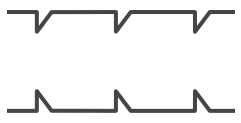

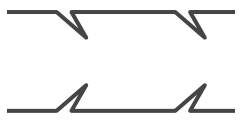

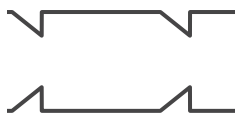

In [5]:
L_x = 500
L_ps = [65, 80, 120, 150]
x2s = [-L_ps[0]/2+ 8.5, -L_ps[1]/2, -L_ps[2]/2 + 30.0, -L_ps[3]/2 + 30.0]
x3s = [-L_ps[0]/2 + 17.0, -L_ps[1]/2 + 15, -L_ps[2]/2 + 15.0, -L_ps[3]/2 + 30.0]

hs = [29.9, 20, 26, 24]
for i in range(4):
    L_p = L_ps[i] 
    x1 = -L_p/2.0
    x2, x3 = x2s[i], x3s[i]
    h = hs[i]

    N_s = 2001
    X0,Y0 = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)
    plt.figure(figsize=(6, 2))
    plt.plot(X0, 100-Y0, color="#464546", linewidth=4.0)
    plt.plot(X0, Y0, color="#464546", linewidth=4.0)
    plt.axis('off'),
    plt.xlim([-230, 0])
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.savefig("design_data_"+str(i)+".pdf")

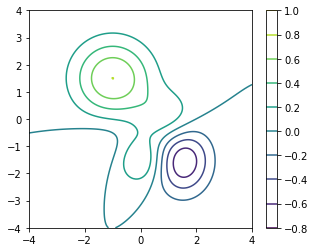

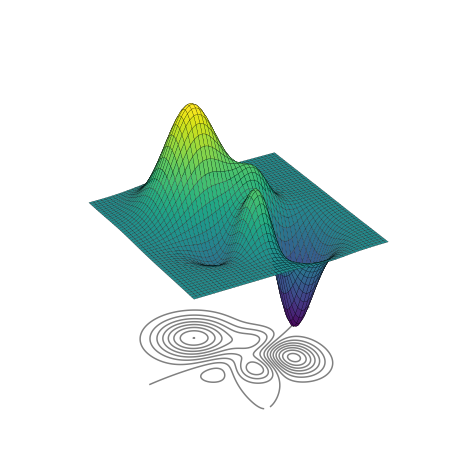

In [131]:
def Gaussian_helper(x, m, C):
    return np.exp(-0.5*np.dot(x - m , np.linalg.solve(C,x - m)))
    
def Gaussian(X, Y, m, C):
    nx, ny = X.shape
    Z = np.zeros((nx, ny))
    for ix in range(nx):
        for iy in range(ny):
            Z[ix, iy] = Gaussian_helper(np.array([X[ix, iy], Y[ix, iy]]), m, C)
    return Z

nx, ny = 200, 200
xx = np.linspace(-4, 4, nx)
yy = np.linspace(-4, 4, ny)
X, Y = np.meshgrid(xx ,yy)


Z = np.zeros((nx, ny))
Z += 0.8*Gaussian(X, Y, np.array([-1.0, 1.5]), np.array([[1.0, 0.0], [0.0, 1.0]]))
Z += 0.4*Gaussian(X, Y, np.array([1.0, 0.0]), np.array([[0.5, 0.0], [0.0, 0.5]]))
Z += 0.5*Gaussian(X, Y, np.array([0.0, -1.5]), np.array([[0.4, 0.0], [0.0, 0.4]]))
Z += -0.2*Gaussian(X, Y, np.array([-1.2, -1.0]), np.array([[0.8, 0.0], [0.0, 0.5]]))
Z += -0.8*Gaussian(X, Y, np.array([1.5, -1.5]), np.array([[0.5, 0.0], [0.0, 0.8]]))

plt.figure(figsize=(5,4))
# plt.pcolormesh(X, Y, Z)
plt.contour(X, Y, Z)
plt.colorbar()


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap="viridis", lw=0.2, linestyles="solid", edgecolors='k', rstride=4, cstride=4)
# # ax.contour(X, Y, Z, 10, lw=3, colors="k", linestyles="solid")
ax.contour(X, Y, Z, 15, colors="grey", linestyles="solid", offset=-1.0)
# ax.set_xlabel("x")
ax.set_axis_off()
# ax.set(zlim=(-0.5, 2))
ax.view_init(30, -120)
fig.savefig("optimization.pdf")
# fig = plt.figure(figsize=(4,3))
# ax = fig.add_subplot(111, projection='3d')

# # Z += np.sin(np.pi*X)*np.sin(np.pi*Y)
# ax.plot_surface(X, Y, Z, cmap="viridis", lw=0.1, rstride=1, cstride=1)
# # # ax.contour(X, Y, Z, 10, lw=3, colors="k", linestyles="solid")
# ax.contour(X, Y, Z, 10, colors="k", linestyles="solid", offset=-0.5)

# ax.set_axis_off()
# ax.set(zlim=(-0.5, 2))
# # ax.view_init(30, 30)
# plt.show()


# fig.axes.get_xaxis().set_visible(False)
# fig.axes.get_yaxis().set_visible(False)
# fig.axes.get_zaxis().set_visible(False)
# 
# # ax.set_xticks([0, -30, -60])
# ax.tick_params(axis='x', which='major', pad=-4)
# ax.set_xlabel(r"$x_2$", labelpad=-5)
# # ax.set_yticks([0, -8, -16])
# ax.tick_params(axis='y', which='major', pad=-4)

# ax.set_ylabel(r"$x_3$", labelpad=-5)
# # ax.set_zticks([3e5, 6e5, 9e5])
# ax.tick_params(axis='z', which='major', pad=-4)

# # ax.ticklabel_format(axis='z', style='scientific',  scilimits=(1,4), useMathText=True)
# fig.tight_layout()
# fig.savefig("landscape-1.pdf")

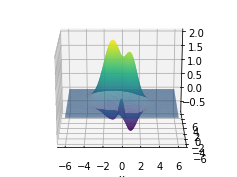

In [87]:

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap="viridis", lw=0.0, rstride=1, cstride=1)
# # ax.contour(X, Y, Z, 10, lw=3, colors="k", linestyles="solid")
# ax.contour(X, Y, Z, 10, colors="k", linestyles="solid", offset=-0.5)
ax.set_xlabel("x")
# ax.set_axis_off()
# ax.set(zlim=(-0.5, 2))
ax.view_init(20, -90)
plt.show()

/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: The following kwargs were not used by contour: 'lw'
  # Remove the CWD from sys.path while we load stuff.
/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: The following kwargs were not used by contour: 'lw'
  # This is added back by InteractiveShellApp.init_path()


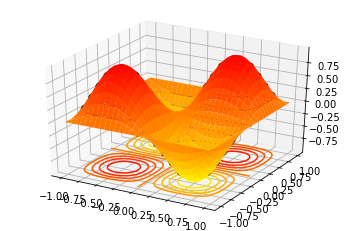

In [90]:
import numpy as np
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
X, Y = np.mgrid[-1:1:30j, -1:1:30j]
Z = np.sin(np.pi*X)*np.sin(np.pi*Y)
ax.plot_surface(X, Y, Z, cmap="autumn_r", lw=0.5, rstride=1, cstride=1)
ax.contour(X, Y, Z, 10, lw=3, cmap="autumn_r", linestyles="solid", offset=-1)
ax.contour(X, Y, Z, 10, lw=3, colors="k", linestyles="solid")
plt.show()

/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: The following kwargs were not used by contour: 'lw'
  


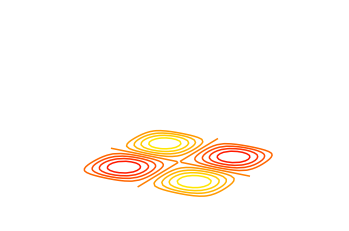

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
X, Y = np.mgrid[-1:1:30j, -1:1:30j]
Z = np.sin(np.pi*X)*np.sin(np.pi*Y)
# ax.plot_surface(X, Y, Z, cmap="viridis", lw=0.0, rstride=1, cstride=1)
ax.contour(X, Y, Z, 10, lw=3, cmap="autumn_r", linestyles="solid", offset=-1)
ax.contour(X, Y, Z, 10, lw=3, colors="k", linestyles="solid")
ax.set_axis_off()
plt.show()